# ETF穿越120日均线

* **买入：**收盘价上穿120日均线
* **卖出：**收盘价下穿120日均线

> 交易价格以每日均价为计算标准；

---

非常简单的策略。但是也只是略高于基准而已。（个人理解好处是可以避免买在山顶上而已，最大回撤降低50%以上）

|        |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |
|-------:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|
| 510300 |   0.583337 |   0.629848 |      0.0787442 |      0.0850226 |      -0.461035 |      -0.176836 |
| 510310 |   0.794892 |   0.905159 |      0.120365  |      0.137062  |      -0.456236 |      -0.192224 |

|        |   剩余现金 |   交易次数 |   未结束交易次数 |   未结束交易购买金额 |   盈利次数 |   亏损次数 | 盈利次数占比   |   盈利(含交易费)次数 |   亏损(含交易费)次数 | 盈利(含交易费)次数占比   |   盈利交易平均获利 |   亏损交易平均亏损 |   盈利(含交易费)交易平均获利 |   亏损(含交易费)交易平均亏损 |   盈亏总额 |   手续费总额 |   手续费均值 | 最大盈利%   | 最大亏损%   | 最大(含交易费)盈利%   | 最大(含交易费)亏损%   |
|-------:|-----------:|-----------:|-----------------:|---------------------:|-----------:|-----------:|:---------------|---------------------:|---------------------:|:-------------------------|-------------------:|-------------------:|-----------------------------:|-----------------------------:|-----------:|-------------:|-------------:|:------------|:------------|:----------------------|:----------------------|
| 510300 |     307.07 |         29 |                1 |              16283.1 |          9 |         19 | 31.03%         |                    9 |                   19 | 31.03%                   |            1347.4  |            -279.81 |                      1347.4  |                      -279.81 |    6810.28 |       220.05 |         3.86 | 81.70%      | -8.39%      | 81.62%                | -8.45%                |
| 510310 |     153.38 |         19 |                1 |              18686.2 |          7 |         11 | 36.84%         |                    7 |                   11 | 36.84%                   |            1912.59 |            -398.69 |                      1912.59 |                      -398.69 |    9002.55 |       162.92 |         4.4  | 83.36%      | -7.58%      | 83.27%                | -7.64%                |

In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()
import talib
import matplotlib.pyplot as plt
import pandas as pd
from abupy.ExtBu.empyrical import stats

you are using non-interactive mdoel quantaxis


# 原始数据

In [19]:
START='1990-01-01'
END='2019-12-31'
DEFAULT_MA=120
CODE='510310'

def get_data(code, start, end,ma=DEFAULT_MA):
    data=QA.QA_fetch_index_day_adv(code,start=start,end=end)
    if not data:
        return None
    data=data.data.reset_index(level=1, drop=True)
    data['MA']=QA.MA(data['close'],ma)
    data['prev_MA']=data['MA'].shift()
    data['prev_close']=data['close'].shift()
    data['date'] = data.index.get_level_values(0)
    data['date'] = pd.to_datetime(data['date'])
    data['avg_price']=(data['close']+data['open']+data['high']+data['low'])/4
    # 星期一为0，星期天为6
    data['weekday'] = data['date'].dt.weekday
    data['nextday']=data['weekday'].shift(-1)
    data['prevday']=data['weekday'].shift()
    return data

In [3]:
# 易方达沪深300发起式ETF
data_000300=get_data('000300',start=START,end=END)
# 易方达沪深300发起式ETF
data_510310=get_data('510310',start=START,end=END)
# 华泰柏瑞沪深300ETF
data_510300=get_data('510300',start=START,end=END)

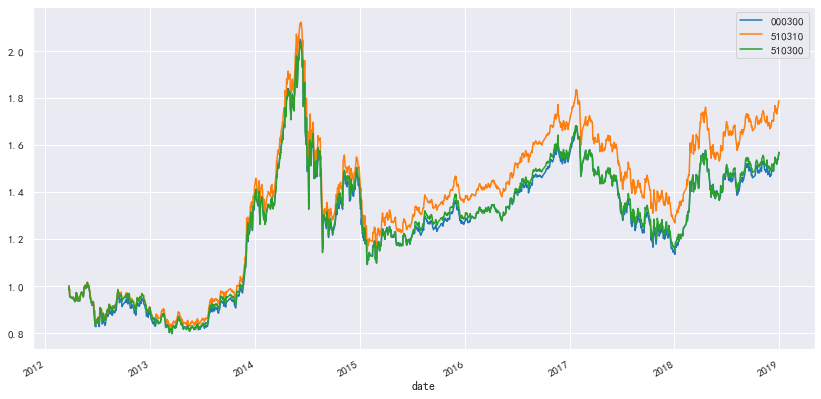

In [4]:
data_close=pd.DataFrame({'000300':data_000300.close,'510310':data_510310.close,'510300':data_510300.close}).dropna()
(data_close/data_close.iloc[0]).plot()
plt.legend()

In [5]:
data_close.pct_change().describe()

,000300,510310,510300
count,1650.0000,1650.0000,1650.0000
mean,0.0004,0.0005,0.0004
std,0.0148,0.0156,0.0158
min,-0.0875,-0.0997,-0.1001
25%,-0.0056,-0.0053,-0.0060
50%,0.0004,0.0000,0.0003
75%,0.0070,0.0066,0.0068
max,0.0671,0.1002,0.0999


In [6]:
data_close.iloc[-1]/data_close.iloc[0]

000300    1.5677
510310    1.7890
510300    1.5687
dtype: float64

<AxesSubplot:xlabel='date'>

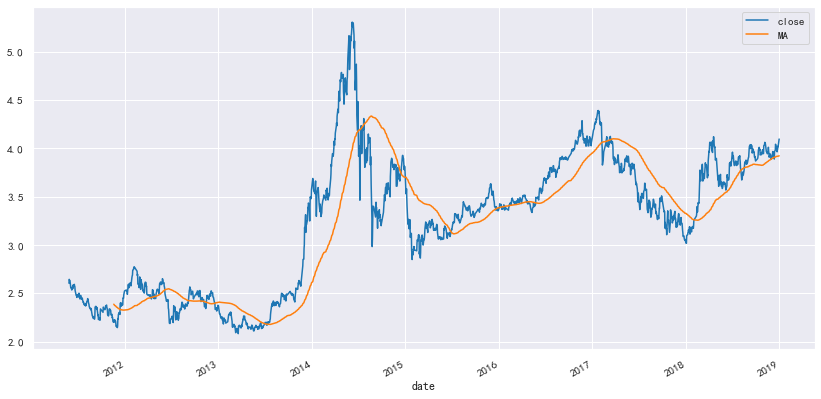

In [7]:
data_510300[['close','MA']].plot()

In [20]:
from gquant.backtest import backtest

def simple_trade_func(data,**kwargs):
    #昨日收盘价大于昨日120日均线价格，并且前日收盘价小于前日120日均线价格时买入
    data.loc[(data['close'].shift()>data['MA'].shift())&(data['prev_close'].shift()<data['prev_MA'].shift()),'buy']=1
    #昨日收盘价小于昨日120日均线价格，并且前日收盘价大于前日120日均线价格时卖出
    data.loc[(data['close'].shift()<data['MA'].shift())&(data['prev_close'].shift()>data['prev_MA'].shift()),'sell']=1
    return data

def simple_buy_price_func(index, row, data):
    return row['avg_price']

def simple_sell_price_func(index, row, data):
    return row['avg_price']

## 510300

In [21]:
x = get_data('510300', START, END)
x=simple_trade_func(x)
m1 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m1.stats()
# m.report().to_frame().T
# m.plot_cash()

1852it [00:00, 4420.66it/s]


基准收益      0.5833
策略收益      0.6298
基准年化收益    0.0787
策略年化收益    0.0850
基准最大回撤   -0.4610
策略最大回撤   -0.1768
dtype: float64

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m1.report())

剩余现金                307.07
交易次数                    29
未结束交易次数                  1
未结束交易购买金额         16283.15
盈利次数                     9
亏损次数                    19
盈利次数占比              31.03%
盈利(含交易费)次数               9
亏损(含交易费)次数              19
盈利(含交易费)次数占比        31.03%
盈利交易平均获利           1347.40
亏损交易平均亏损           -279.81
盈利(含交易费)交易平均获利     1347.40
亏损(含交易费)交易平均亏损     -279.81
盈亏总额               6810.28
手续费总额               220.05
手续费均值                 3.86
最大盈利%               81.70%
最大亏损%               -8.39%
最大(含交易费)盈利%         81.62%
最大(含交易费)亏损%         -8.45%
dtype: object


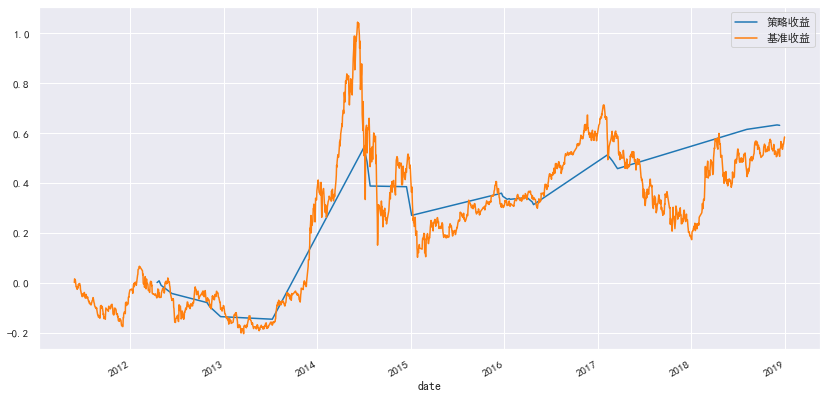

In [23]:
m1.plot_cash()

## 510310

In [24]:
x = get_data('510310', START, END)
x=simple_trade_func(x)
m2 = backtest(x, benchmark_pd=x, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
             buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
m2.stats()
# m.report().to_frame().T
# m.plot_cash()

1651it [00:00, 4619.94it/s]


基准收益      0.7949
策略收益      0.9052
基准年化收益    0.1204
策略年化收益    0.1371
基准最大回撤   -0.4562
策略最大回撤   -0.1922
dtype: float64

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(m2.report())

剩余现金                153.38
交易次数                    19
未结束交易次数                  1
未结束交易购买金额         18686.25
盈利次数                     7
亏损次数                    11
盈利次数占比              36.84%
盈利(含交易费)次数               7
亏损(含交易费)次数              11
盈利(含交易费)次数占比        36.84%
盈利交易平均获利           1912.59
亏损交易平均亏损           -398.69
盈利(含交易费)交易平均获利     1912.59
亏损(含交易费)交易平均亏损     -398.69
盈亏总额               9002.55
手续费总额               162.92
手续费均值                 4.40
最大盈利%               83.36%
最大亏损%               -7.58%
最大(含交易费)盈利%         83.27%
最大(含交易费)亏损%         -7.64%
dtype: object


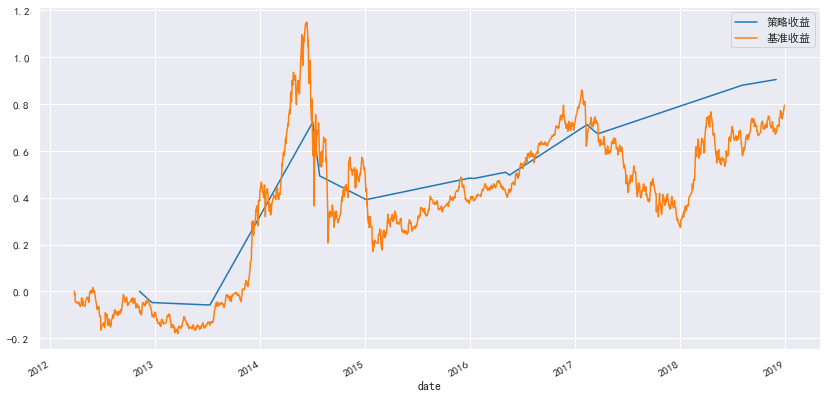

In [26]:
m2.plot_cash()

In [27]:
print(pd.DataFrame({'510300':m1.stats(),'510310':m2.stats()}).T.to_markdown())

|        |   基准收益 |   策略收益 |   基准年化收益 |   策略年化收益 |   基准最大回撤 |   策略最大回撤 |
|-------:|-----------:|-----------:|---------------:|---------------:|---------------:|---------------:|
| 510300 |   0.583337 |   0.629848 |      0.0787442 |      0.0850226 |      -0.461035 |      -0.176836 |
| 510310 |   0.794892 |   0.905159 |      0.120365  |      0.137062  |      -0.456236 |      -0.192224 |


In [28]:
print(pd.DataFrame({'510300':m1.report(),'510310':m2.report()}).T.to_markdown())

|        |   剩余现金 |   交易次数 |   未结束交易次数 |   未结束交易购买金额 |   盈利次数 |   亏损次数 | 盈利次数占比   |   盈利(含交易费)次数 |   亏损(含交易费)次数 | 盈利(含交易费)次数占比   |   盈利交易平均获利 |   亏损交易平均亏损 |   盈利(含交易费)交易平均获利 |   亏损(含交易费)交易平均亏损 |   盈亏总额 |   手续费总额 |   手续费均值 | 最大盈利%   | 最大亏损%   | 最大(含交易费)盈利%   | 最大(含交易费)亏损%   |
|-------:|-----------:|-----------:|-----------------:|---------------------:|-----------:|-----------:|:---------------|---------------------:|---------------------:|:-------------------------|-------------------:|-------------------:|-----------------------------:|-----------------------------:|-----------:|-------------:|-------------:|:------------|:------------|:----------------------|:----------------------|
| 510300 |     307.07 |         29 |                1 |              16283.1 |          9 |         19 | 31.03%         |                    9 |                   19 | 31.03%                   |            1347.4  |            -279.81 |                      1347.4  |                      -279.81 |    6810

## 逐年统计

从`2014-01-01`至`2020-12-31`期间，每年从`01-01`开始投入`10000`元，以`510310`穿越120日均线为简单条件进行测试。

最后统计 `持仓数量\*最后一个交易日的收盘价+剩余现金` 作为**策略浮动盈亏**，与`基准数据最后一个交易日收盘价/基准数据第一个交易日开盘价`**基准浮动盈亏**进行对比。最终结果累加值稍高于基准。

**但是交易频率过低。** 很难对收益率、最大回撤等指标进行比较。

|                       |   浮动盈亏_cumsum |   基准浮动盈亏_cumsum |   浮动盈亏 |   基准浮动盈亏 |
|:----------------------|------------------:|----------------------:|-----------:|---------------:|
| 2014-01-01~2014-12-31 |           1.64544 |               1.55628 |   1.64544  |       1.55628  |
| 2015-01-01~2015-12-31 |           2.62285 |               2.6133  |   0.977413 |       1.05702  |
| 2016-01-01~2016-12-31 |           3.70216 |               3.5215  |   1.07931  |       0.908197 |
| 2017-01-01~2017-12-31 |           4.93764 |               4.75471 |   1.23548  |       1.23321  |
| 2018-01-01~2018-12-31 |           5.96356 |               5.51567 |   1.02592  |       0.760959 |
| 2019-01-01~2019-12-31 |           7.23644 |               6.90358 |   1.27288  |       1.38791  |
| 2020-01-01~2020-12-31 |           8.61473 |               8.19969 |   1.3783   |       1.29611  |

In [29]:
d={}
xs={}
rps={}
x = get_data('510310', START, '2020-12-31')
for i in range(2014,2021):
    start='{}-01-01'.format(i)
    end='{}-12-31'.format(i)
    y=x.loc[start:end]
    y=simple_trade_func(y)
    m = backtest(y, benchmark_pd=y, buy_comm=0, sell_comm=0, buy_limit_comm=0, sell_limit_comm=0,
                     buy_price_func=simple_buy_price_func, sell_price_func=simple_sell_price_func)
    d['{}~{}'.format('{}-01-01'.format(i),end)]=m.stats()
    rp=m.report()
    rp['未结束交易当前价值']=m.x_df[m.x_df['sell_price'].isna()].buy_amount.sum()*m.benchmark_pd.iloc[-1]['close']
    rp['结算价值']=rp['未结束交易当前价值']+float(rp['剩余现金'])
    rp['浮动盈亏']=rp['结算价值']/m.init_cash
    rp['基准浮动盈亏']=m.benchmark_pd.iloc[-1]['close']/m.benchmark_pd.iloc[0]['open']
    rps['{}~{}'.format('{}-01-01'.format(i),end)]=rp

245it [00:00, 4920.98it/s]
244it [00:00, 4673.49it/s]
244it [00:00, 4445.65it/s]
244it [00:00, 4371.94it/s]
243it [00:00, 4328.69it/s]
244it [00:00, 4557.60it/s]
243it [00:00, 4088.39it/s]


In [30]:
rps=pd.DataFrame(rps)
print(rps.T[['浮动盈亏','基准浮动盈亏']].cumsum().join(rps.T[['浮动盈亏','基准浮动盈亏']],lsuffix='_cumsum').to_markdown())

|                       |   浮动盈亏_cumsum |   基准浮动盈亏_cumsum |   浮动盈亏 |   基准浮动盈亏 |
|:----------------------|------------------:|----------------------:|-----------:|---------------:|
| 2014-01-01~2014-12-31 |           1.61829 |               1.55628 |   1.61829  |       1.55628  |
| 2015-01-01~2015-12-31 |           2.48114 |               2.6133  |   0.862849 |       1.05702  |
| 2016-01-01~2016-12-31 |           3.54751 |               3.5215  |   1.06637  |       0.908197 |
| 2017-01-01~2017-12-31 |           4.75136 |               4.75471 |   1.20385  |       1.23321  |
| 2018-01-01~2018-12-31 |           5.72889 |               5.51567 |   0.977528 |       0.760959 |
| 2019-01-01~2019-12-31 |           6.94414 |               6.90358 |   1.21525  |       1.38791  |
| 2020-01-01~2020-12-31 |           8.21375 |               8.19969 |   1.26961  |       1.29611  |
